In [84]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import Mors as mors
import scipy.integrate as integrate
from math import nan
import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap, ListedColormap


In [2]:
masses = np.arange(0.3,1.0,0.1)

#saving new stars, only run this cell once
for i,mass in enumerate(masses):
    star = mors.Star(Mstar = mass, percentile=50)
    star.Save(filename = 'p50_m'+str(mass)+'.pickle')
    

for i,mass in enumerate(masses):
    star = mors.Star(Mstar = mass, percentile=10)
    star.Save(filename = 'p10_m'+str(mass)+'.pickle')

for i,mass in enumerate(masses):
    star = mors.Star(Mstar = mass, percentile=90.0)
    star.Save(filename = 'p90_m'+str(mass)+'.pickle')


In [4]:
star = mors.Star(Mstar = 1.0, percentile=10)
star.Save(filename = 'p10_m'+str(1)+'.pickle')

star = mors.Star(Mstar = 1.0, percentile=50)
star.Save(filename = 'p50_m'+str(1)+'.pickle')

star = mors.Star(Mstar = 1.0, percentile=90)
star.Save(filename = 'p90_m'+str(1)+'.pickle')

In [ ]:
#Plot the Lx curves for different speeds and masses
#Similar to what I did in the previous notebook, plot how evaporation time changes with mass
#Also put all the fast %mass curves together, 50ths with 50ths etc

In [96]:
def LxTrack(mass):
    #efficiency between 0-1
    #M_pl in fraction of earth
    #R_pl in fraction of earth


    #need flux over course of time for each case of rotator
    p10 = mors.Load('Refined/rp10/p10_m'+str(mass)+'.pickle')
    p50 = mors.Load('Refined/rp50/p50_m'+str(mass)+'.pickle')
    p90 = mors.Load('Refined/rp90/p90_m'+str(mass)+'.pickle')

    #need age range
    t = np.linspace(10,5000,10000)

    p10_Lx = np.empty(len(t))
    p50_Lx = np.empty(len(t))
    p90_Lx = np.empty(len(t))
    
    for i,age in enumerate(t):
        p10_Lx[i] = p10.Value(Age = age, Quantity='Lx')
        p50_Lx[i] = p50.Value(Age = age, Quantity = 'Lx')
        p90_Lx[i] = p90.Value(Age = age, Quantity = 'Lx')

    
    '''
    plt.plot(t,p10_Lx)
    plt.plot(t,p50_Lx)
    plt.plot(t,p90_Lx)
    plt.yscale('log')
    plt.xscale('log')
    plt.title('Lx Tracks for mass='+str(mass))
    plt.xlabel('Age (10Myr-5Gyr)')
    plt.ylabel('Lx (erg s-1)')
    plt.figure()'''
    return p10_Lx,p50_Lx,p90_Lx

In [38]:
def findHZ(M_star,age):
    '''
    M_star in solar masses
    age in Myr
    '''
    
    HZbounds = np.empty((len(age),2))
    
    for i,t in enumerate(age):
        HZbounds[i]=(np.array([mors.aOrbHZ(Mstar=M_star,Age=t)['RecentVenus'],mors.aOrbHZ(Mstar=M_star, Age=t)['EarlyMars']]))

    #initial overlap is just the first HZ range
    overlap = HZbounds[0]
    
    for i,array in enumerate(HZbounds[1:]):
        if max(overlap[0], array[0]) <= min(overlap[1], array[1]):
            overlap = np.array((max(overlap[0], array[0]), min(overlap[1], array[1])))
    return overlap

In [82]:
def massLossRate(efficiency, M_pl, R_pl, M_star,chz):
    #efficiency between 0-1
    #M_pl in fraction of earth
    #R_pl in fraction of earth

    #need to get M_pl in actual mass
    Mp = M_pl * 5.97E24 #kg


    #same for R_pl
    Rp = R_pl * 6.37E6 #m

    #need flux over course of time for each case of rotator
    p10 = mors.Load('Refined/rp10/p10_m'+str(M_star)+'.pickle')
    p50 = mors.Load('Refined/rp50/p50_m'+str(M_star)+'.pickle')
    p90 = mors.Load('Refined/rp90/p90_m'+str(M_star)+'.pickle')

    #need age range
    t = np.linspace(10,5000,10000)


    p10_Lx = np.empty(len(t))
    p50_Lx = np.empty(len(t))
    p90_Lx = np.empty(len(t))
    p10_Leuv = np.empty(len(t))
    p50_Leuv = np.empty(len(t))
    p90_Leuv = np.empty(len(t))
    
    for i,age in enumerate(t):
        p10_Lx[i] = p10.Value(Age = age, Quantity='Lx')
        p10_Leuv[i] = p10.Value(Age = age, Quantity='Leuv')
        
        p50_Lx[i] = p50.Value(Age = age, Quantity = 'Lx')
        p50_Leuv[i] = p50.Value(Age = age, Quantity='Leuv')
        
        p90_Lx[i] = p90.Value(Age = age, Quantity = 'Lx')
        p90_Leuv[i] = p90.Value(Age = age, Quantity='Leuv')

    
    #F=L/4pir^2
    #need to find the orbital distance within the CHZ using findHZ
    r = chz * 1.496E13
    
    p10_flux = (p10_Lx + p10_Leuv)/(4 * np.pi * r**2)
    p50_flux = (p50_Lx + p50_Leuv)/(4 * np.pi * r**2)
    p90_flux = (p90_Lx + p90_Leuv)/(4 * np.pi * r**2)
    
    #need radius of atmosphere
    R_atm = Rp*1.1 #meters

    #gravitational constant
    G = 6.67E-11 #si
    
    
    M_atm = 5E-3*Mp
    Mdot10 = np.pi*efficiency*p10_flux*R_atm**2*Rp/(G*Mp)   
    Mdot50 = np.pi*efficiency*p50_flux*R_atm**2*Rp/(G*Mp)  
    Mdot90 = np.pi*efficiency*p90_flux*R_atm**2*Rp/(G*Mp)
    
    
    #put Mdot in kg/year
    Mdot10_kg = Mdot10*1E-3*3.15E7
    Mdot50_kg = Mdot50*1E-3*3.15E7
    Mdot90_kg = Mdot90*1E-3*3.15E7
   
    M10 = (M_atm - integrate.cumtrapz(y=Mdot10_kg, x=t*1e6)) / M_atm *100
    M50 = (M_atm - integrate.cumtrapz(y=Mdot50_kg, x=t*1e6)) / M_atm *100
    M90 = (M_atm - integrate.cumtrapz(y=Mdot90_kg, x=t*1e6)) / M_atm *100

    plt.plot(t[1:],M10,color='green')
    plt.plot(t[1:],M50)
    plt.plot(t[1:],M90)
    plt.yscale('log')
    plt.xscale('log')
    plt.ylim([1,1E2])
    plt.title('%mass remaining over time m='+str(mass))
    plt.xlabel('Age (10Myr-5Gyr)')
    plt.ylabel('% mass')

    if len(t[np.where(M10<=1)]) != 0:
        return t[np.where(M10 <= 1)][0], t[np.where(M50 <= 1)][0], t[np.where(M90 <= 1)][0]
    elif len(t[np.where(M50 <= 1)]) != 0:
        return nan,t[np.where(M50 <= 1)][0], t[np.where(M90 <= 1)][0]
    elif len(t[np.where(M90 <= 1)]) != 0:
        return nan,nan, t[np.where(M90 <= 1)][0]
    else:
        return nan,nan,nan

In [ ]:
columns = ['Mass','CHZ','AAL(10th)','AAL(50th)','AAL(90th)'] #AAL - Age at atmosphere lost
all_data = pd.DataFrame(columns=columns)
all_data['Mass'] = np.arange(0.3,1.1,0.1)
all_data['CHZ'] = [np.mean(findHZ(round(mass,1),age=np.linspace(10,5000,50))) for mass in all_data['Mass']]
for i,mass in enumerate(all_data['Mass']):
    ages = massLossRate(0.3,0.5,1,round(mass,1),all_data['CHZ'][i])
    all_data['AAL(10th)'][i] = ages[0]
    all_data['AAL(50th)'][i] = ages[1]
    all_data['AAL(90th)'][i] = ages[2]

In [80]:
all_data['Mass'] = np.arange(0.3,1.1,0.1)
all_data['Mass']=round(all_data['Mass'],1)
all_data['Mass']

0    0.3
1    0.4
2    0.5
3    0.6
4    0.7
5    0.8
6    0.9
7    1.0
Name: Mass, dtype: float64

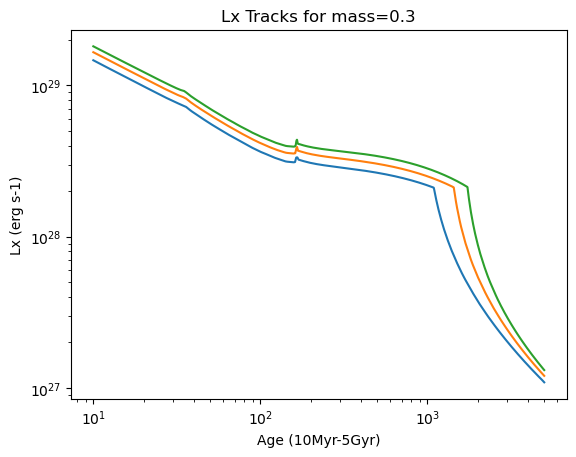

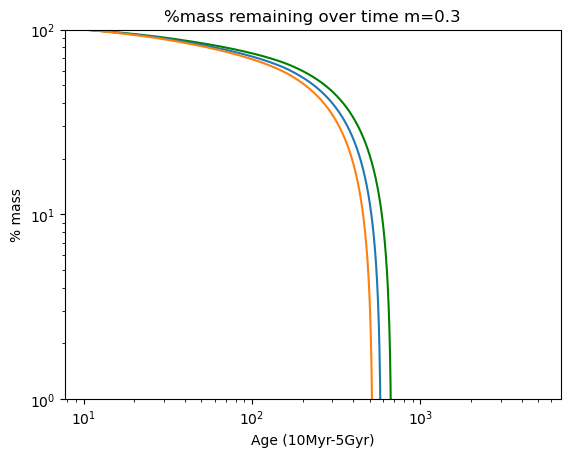

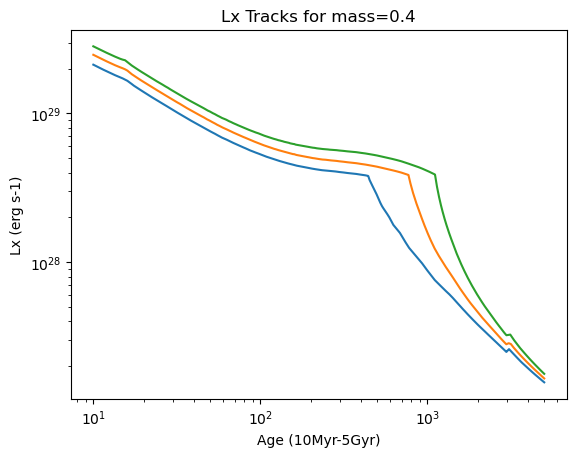

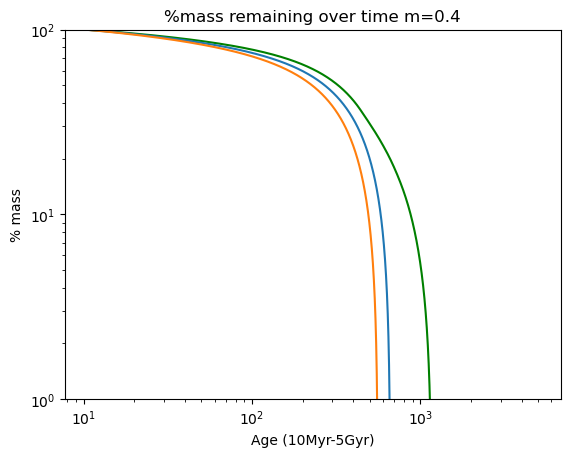

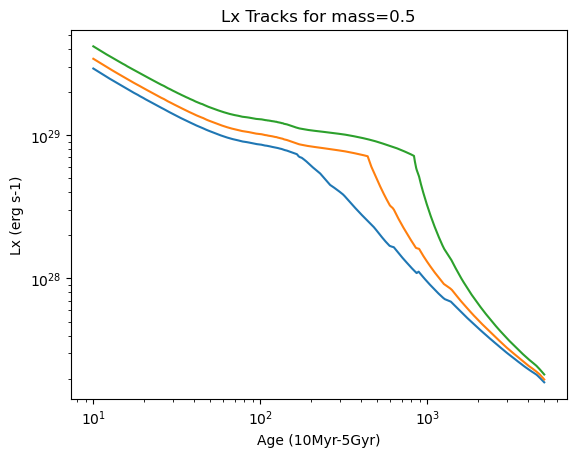

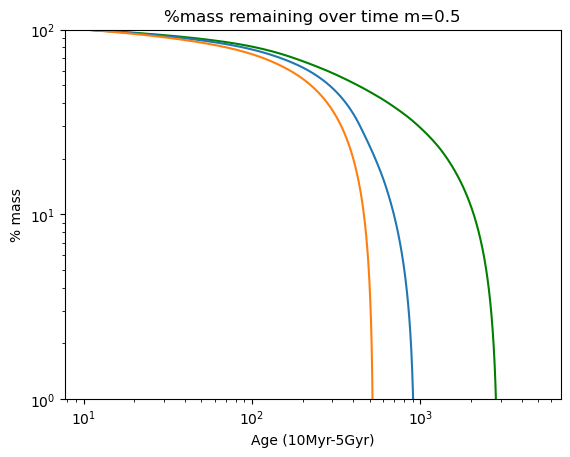

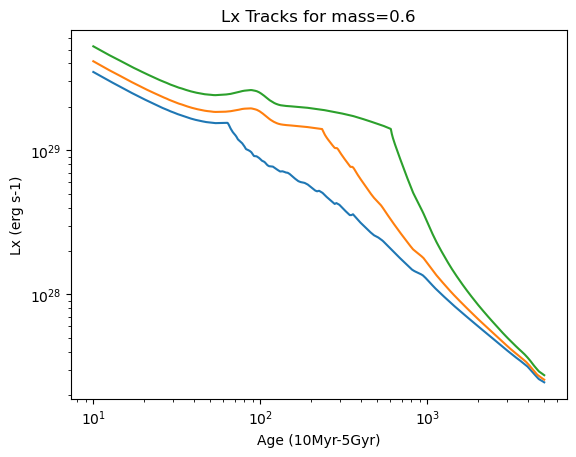

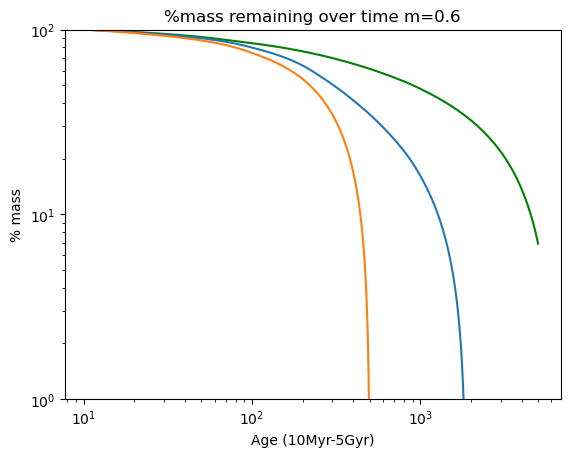

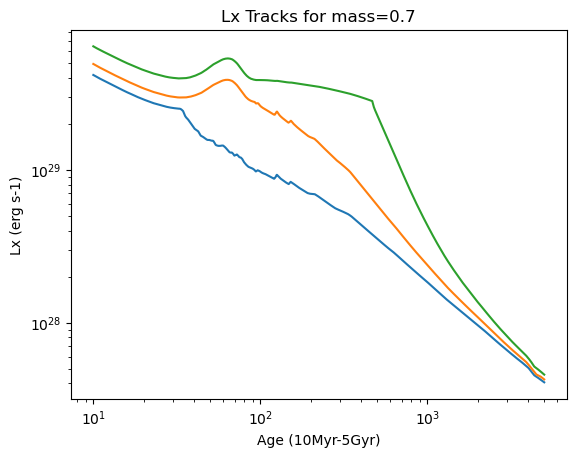

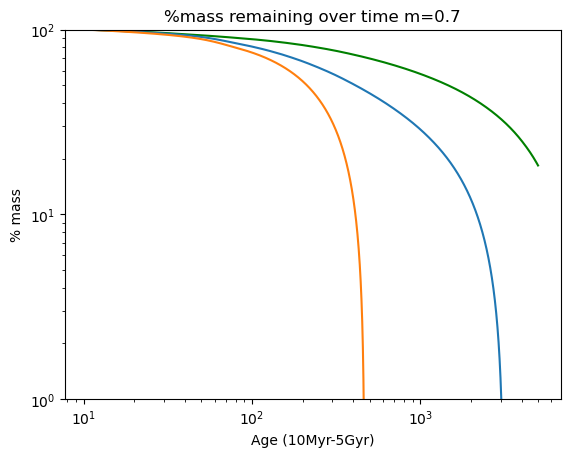

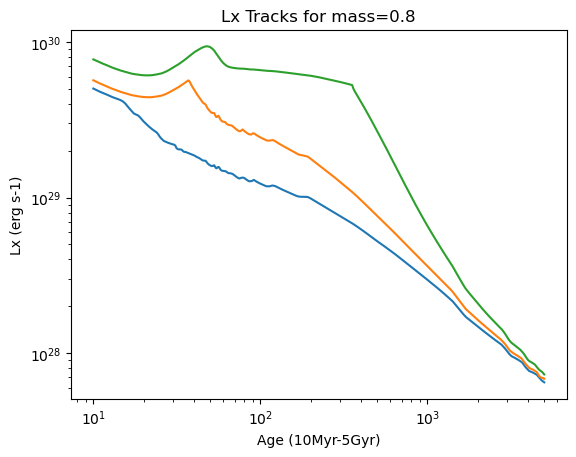

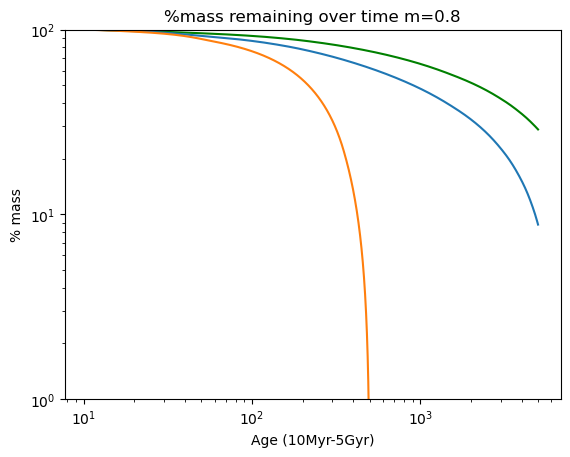

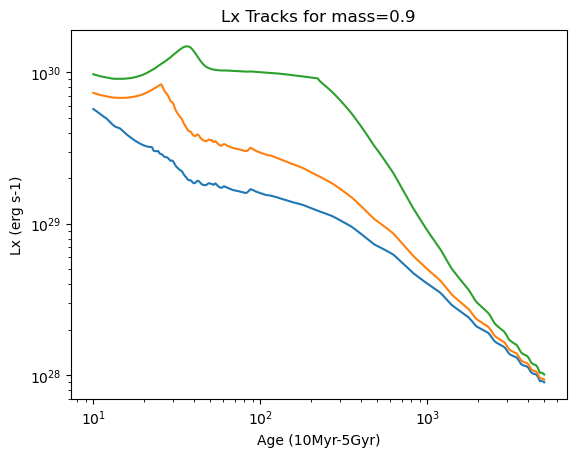

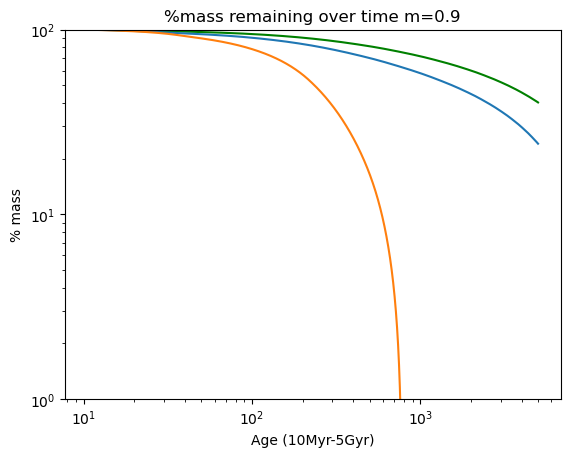

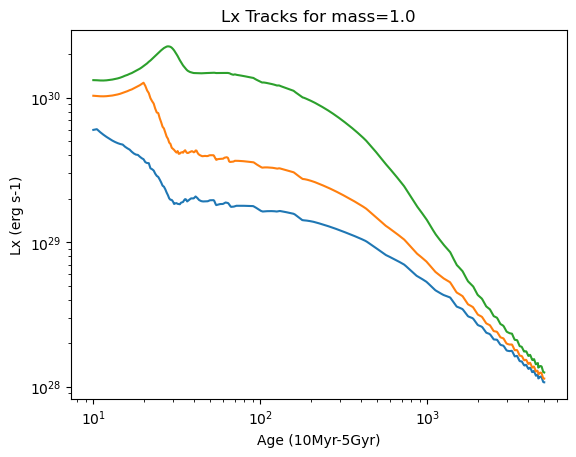

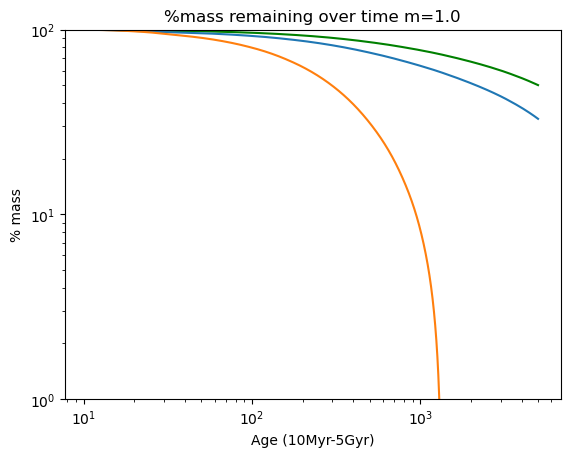

<Figure size 640x480 with 0 Axes>

In [83]:
for i,mass in enumerate(all_data['Mass']):
    LxTrack(mass)
    plt.figure()
    massLossRate(0.3,0.5,1,mass,all_data['CHZ'][i])
    plt.figure()

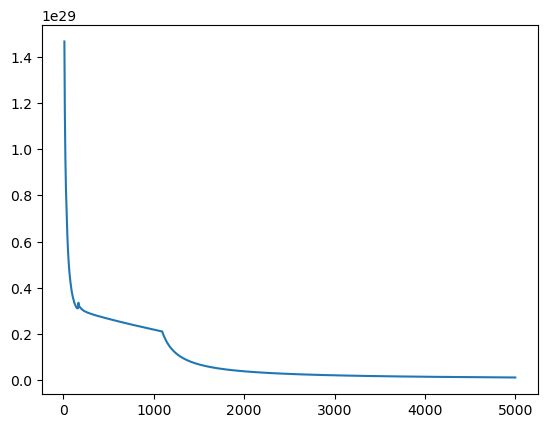

In [97]:
y=LxTrack(0.3)[0]
plt.plot(np.linspace(10,5000,10000),y)

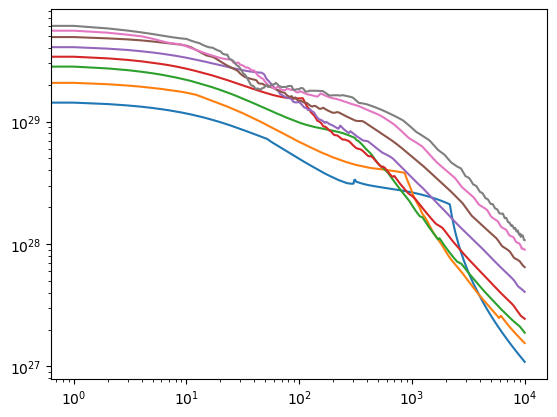

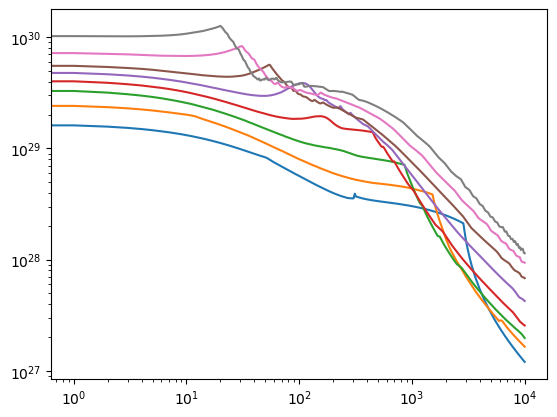

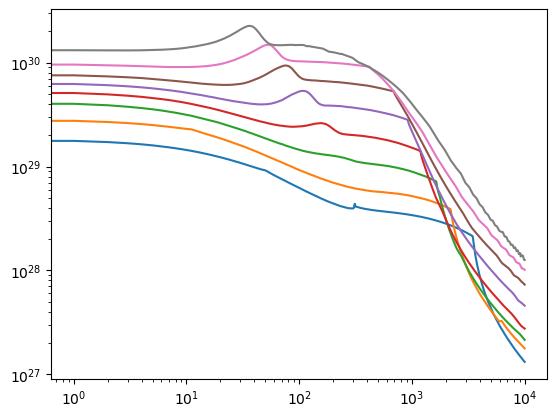

In [102]:
#now plot all of the luminosity curves same speeds together
for mass in all_data['Mass']:
    plt.plot(LxTrack(mass)[0])
plt.title('Lx tracks for 10th percentile rotators')
plt.xlabel('')
plt.xscale('log')
plt.yscale('log')

plt.figure()
plt.xscale('log')
plt.yscale('log')
for mass in all_data['Mass']:
    plt.plot(LxTrack(mass)[1])
plt.figure()
plt.xscale('log')
plt.yscale('log')
for mass in all_data['Mass']:
    plt.plot(LxTrack(mass)[2])
